**The Aim of this project is to predict the solubility of molecules (LogS values).** It should be noted that the solubility of drugs is an important physiochemical property in drug discovery, design and development. Herein, i will be reproducing a research article entitled **"ESOL: Estimating Aqueous Solubility Directly from Molecular Structure"** by John S. Delaney.

In [1]:
!pip install rdkit
# The rdkit Library is a python library that allows us to handle chemical structures
# and the calculation of their molecular properties 
# (i.e. for quantitating the molecular features of each molecule that we can subsequently
# use in the development of machine learning model).

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Dataset**

In [2]:
# Read the dataset
import pandas as pd
df = pd.read_csv('/content/delaney.csv')
df.head(3)

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl


**Examining the SMILES data**

Chemical structures are encoded by string of text known as the **SMILES** notation which is an acronym for **Simplified Molecular-Input Line-Entry System**. 

In [3]:
df.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

------------------------------------------------------------------------------------------------------------------------

**Working with SMILES string**

1. **convert a molecule from the SMILES string to an rdkit object**

In [4]:
from rdkit import Chem

In [5]:
Chem.MolFromSmiles(df.SMILES[0]) # MolFromSmiles() function is used to convert SMILES string to an rdkit molecule object

In [6]:
# Working with the rdkit object
# count the number of atoms using GetNumAtoms() function

m = Chem.MolFromSmiles(df.SMILES[0])
m.GetNumAtoms()

6

In [7]:
# Converting list of molecules to rdkit object

mol_list = []
for element in df.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)
print(len(mol_list))
mol_list[:5]

1144


**Calculate Molecular Descriptors**

we will now represent each of the molecules in the dataset by a set of molecular descriptors that will be used for model building.


To predict **LogS** (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:

1. **cLogP** (*Octanol-water partition coefficient*)
2. **MW** *(Molecular Weight)*
3. **RB** *(Number of rotatable bonds)*
4. **AP** *(Aromatic proportion = number of aromatic atoms/number of heavy atoms)*

unfortunately, rdkit computes the first 3.

In [8]:
# Calculating LogP, MW and RB descriptors

import numpy as np
from rdkit.Chem import Descriptors

def generate(smiles, verbose=False):

  moldata = []
  for elem in smiles:
    mol = Chem.MolFromSmiles(elem)
    moldata.append(mol)

  baseData = np.arange(1,1)
  i = 0
  for mol in moldata:
    desc_MolLogP = Descriptors.MolLogP(mol)
    desc_MolWt = Descriptors.MolWt(mol)
    desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)

    row = np.array([desc_MolLogP, desc_MolWt, desc_NumRotatableBonds]
                   )
    if(i==0):
      baseData = row
    else:
      baseData = np.vstack([baseData, row])
    i = i+1
  
  columnNames = ["MolLogP","MolWt","NumRotatableBonds"]
  descriptors = pd.DataFrame(data=baseData, columns=columnNames)

  return descriptors

In [9]:
df1 = generate(df.SMILES)
df1

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


**Calculating the Aromatic proportion**

The equation for calculating the aromatic proportion is obtained by dividing the number of aromatic atoms by the number of heavy atoms.

------------------------------------------
*Nmber of aromatic atoms*

In [10]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [11]:
AromaticAtoms(m) # Applying using the aromaticatom function to compute the number of atoms for a query SMILES string.

0

This means that there are 19 aromatic atoms (that is there are 19 atoms that are a part of aromatic rings)


Let’s now scale up and apply this to the entire SMILES list

In [12]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

--------------------------------------------------
*Number of heavy atoms*

In [13]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

---------------------------------------
**Computing the aromatic proportion (AP) descriptor**

In [14]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [15]:
columnNames = ["AromaticProportion"]
df2 = pd.DataFrame(data=desc_AromaticProportion, columns=columnNames)
df2

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


**Dataet preparation**

**Creating the X matrix**


Let’s combine all computed descriptors from 2 dataframe into 1 dataframe.

In [16]:
X = pd.concat([df1,df2], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


**Creating Y matrix/Target Variable**

In [17]:
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [18]:
Y = df.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

-------------------------------------------
**Data Split**

Performing data splitting using a split ratio of 80/20 (i.e. we do this by assigning the test_size parameter to 0.2) whereby 80% of the initial dataset will be used as the training set and the remaining 20% of the dataset will be used as the testing set.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2)

-------------------------------------------
**Linear Regression Model**


In [20]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

------------------------------------------
**Predict the LogS value of X_train data**

In [21]:
Y_pred_train = model.predict(X_train)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.74301501 -0.00657346 -0.01225943 -0.42587403]
Intercept: 0.2741628065256614
Mean squared error (MSE): 0.99
Coefficient of determination (R^2): 0.78


Let’s analyse the above output line by line:

1. In the first line, Coefficients lists the regression coefficient values of each independent variables (i.e. the 4 molecular descriptors consisting of LogP, MW, RB and AP).
2. In the second line, Intercept is essentially the y-intercept value where the regression line passes when X = 0.
3. In the third line, Mean squared error (MSE) is used as an error measure (i.e. the lower the better).
4. In the fourth line, Coefficient of determination (R²) is the squared value of Pearson’s correlation coefficient value and is used as a measure of goodness of fit for linear regression models (i.e. the higher the better)

-----------------------------------
**Predict the LogS value of X_test data**

In [22]:
Y_pred_test = model.predict(X_test)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.74301501 -0.00657346 -0.01225943 -0.42587403]
Intercept: 0.2741628065256614
Mean squared error (MSE): 1.10
Coefficient of determination (R^2): 0.73


**Deriving the Linear Regression Equation**

*Based on the Train set*

In [23]:
yintercept = '%.2f' % model.intercept_
LogP = '%.2f LogP' % model.coef_[0]
MW = '%.4f MW' % model.coef_[1]
RB = '%.4f RB' % model.coef_[2]
AP = '%.2f AP' % model.coef_[3]
print('LogS = ' + 
      ' ' + 
      yintercept + 
      ' ' + 
      LogP + 
      ' ' + 
      MW + 
      ' ' + 
      RB + 
      ' ' + 
      AP)

LogS =  0.27 -0.74 LogP -0.0066 MW -0.0123 RB -0.43 AP


*Based on the Full dataset*

In [24]:
full = linear_model.LinearRegression()
full.fit(X, Y)

LinearRegression()

In [25]:
full_pred = model.predict(X)
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, full_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.2565006830997185
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


In [26]:
full_yintercept = '%.2f' % full.intercept_
full_LogP = '%.2f LogP' % full.coef_[0]
full_MW = '%.4f MW' % full.coef_[1]
full_RB = '+ %.4f RB' % full.coef_[2]
full_AP = '%.2f AP' % full.coef_[3]
print('LogS = ' + 
      ' ' + 
      full_yintercept + 
      ' ' + 
      full_LogP + 
      ' ' + 
      full_MW + 
      ' ' + 
      full_RB + 
      ' ' + 
      full_AP)

LogS =  0.26 -0.74 LogP -0.0066 MW + 0.0032 RB -0.42 AP


---------------------------------------------


**Scatter plot of experimental vs predicted LogS**

In [27]:
Y_train.shape, Y_pred_train.shape # dimension of traininf set

((915,), (915,))

In [28]:
Y_test.shape, Y_pred_test.shape # dimension of test set

((229,), (229,))

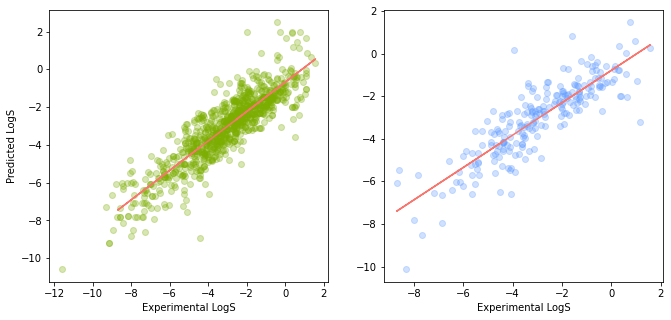

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,5))
# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()